# Does PySINDy performance vary with the level of chaos or level of syntactic complexity? 

This notebook investigates a large database of chaotic systems of pure polynomial expression and polynomial degree <= 4, in order to see if the performance of PySINDy varies with the level of chaos (as measured by the largest Lyapunov exponent) or the level of syntactic complexity.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
import time

# Annoyingly requires the neurokit2 package - "pip install neurokit2"
from dysts.analysis import sample_initial_conditions

import pysindy as ps

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

# Chaotic System Initialization

This experiment include 77 chaotic systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [2]:
t1 = time.time()

# experimental system list
systems_list = ["Aizawa", "Arneodo", "Bouali", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                # Added a bunch of additional polynomial systems
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "AtmosphericRegime", "Hadley", "HindmarshRose",
                ]


# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "embedding_dimension"
]

# Get training and testing trajectories for all the experimental systems and their attributes
n = 5000
all_sols_train = dict()
all_sols_test = dict()
all_t_train = dict()
all_t_test = dict()
all_properties = dict()

for equation_name in systems_list:
    eq = getattr(flows, equation_name)()
    print(eq)
    try:
        ic_train, ic_test = sample_initial_conditions(eq, 2, traj_length=1000, pts_per_period=30)
        eq.ic = ic_train
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_train[equation_name] = sol
        all_t_train[equation_name] = t_sol
        eq.ic = ic_test
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=True, return_times=True, standardize=False)
        all_sols_test[equation_name] = sol
        all_t_test[equation_name] = t_sol
        attr_vals = [getattr(eq, item, None) for item in attributes]
        all_properties[equation_name] = dict(zip(attributes, attr_vals))
    except SystemError:
        print('Could not load one of the systems: ', equation_name)
    except TypeError:
        print('Could not load one of the systems ', equation_name)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
Arneodo(name='Arneodo', params={'a': -5.5, 'b': 4.5, 'c': 1.0, 'd': -1.0}, random_state=None)
Bouali(name='Bouali', params={'a': 1.0, 'b': -0.3, 'bb': 1.0, 'c': 0.05, 'g': 1.0, 'm': 1, 'y0': 4.0}, random_state=None)
GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
HyperBao(name='HyperBao', params={'a': 36, 'b': 3, 'c': 20, 'd': 0.1, 'e': 21}, random_state=None)
HyperCai(name='HyperCai', params={'a': 27.5, 'b': 3, 'c': 19.3, 'd': 2.9, 'e': 3.3}, random_state=None)
HyperJha(name='HyperJha', params={'a': 10, 'b': 28, 'c': 2.667, 'd': 1.3}, random_state=None)
HyperLorenz(name='HyperLorenz', params={'a': 10, 'b': 2.667, 'c': 28, 'd': 1.1}, random_state=None)
HyperLu(name='HyperLu', params={'a': 36, 'b': 3, 'c': 20, 'd': 1.3}, random_state=None)
HyperPang(name='HyperPang', params={'a': 36, 'b': 3, 'c': 20, 'd': 2}, random_state=None)
Laser(na

## Trajectory Visualization

Took  2.4785077571868896  seconds to plot the systems


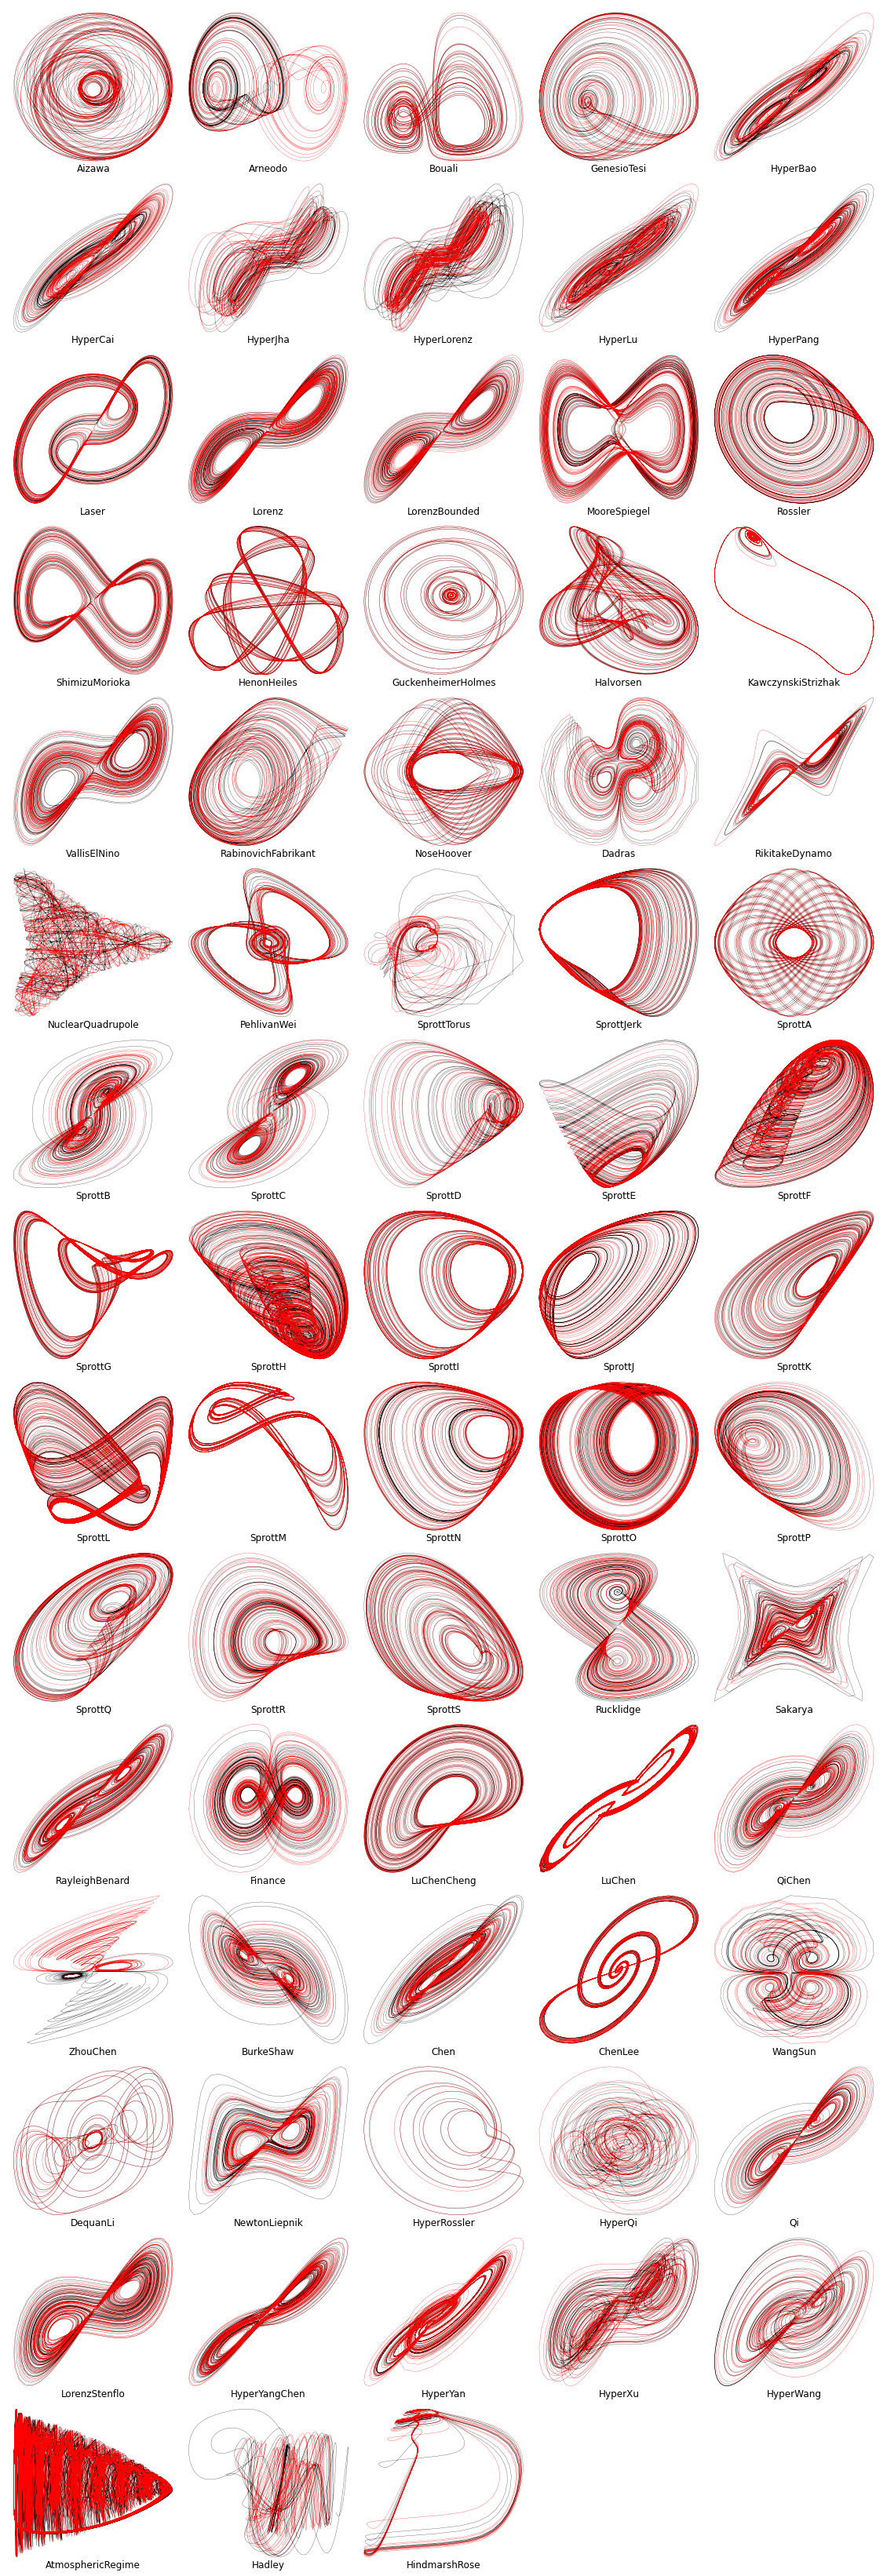

In [3]:
t1 = time.time()

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    plt.gca().axis('off')
            
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')

## Distribution of Chaotic Properties

Visulizes the distribution of Lyapunov exponents for the 77 chaotic systems.

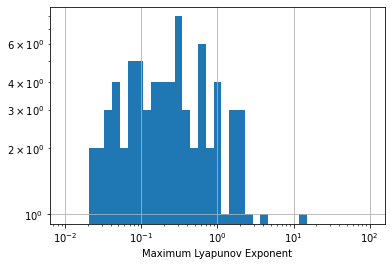

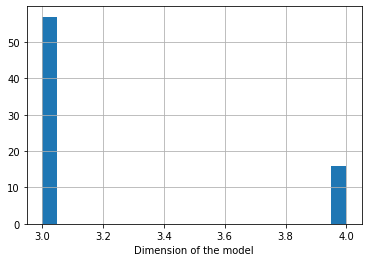

In [4]:
import matplotlib.pyplot as plt

plt.figure()
lyap_list = []
dimension_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])


# maximum lyapunov estimated
chaotic_levels = np.logspace(-2, 2, 40)
plt.hist(lyap_list, bins=chaotic_levels, log=True)
plt.xlabel('Maximum Lyapunov Exponent')
plt.xscale('log')
plt.grid(True)

plt.figure()
plt.hist(dimension_list, bins=20)
plt.xlabel('Dimension of the model')
plt.grid(True)

# Algorithm 2 from Rudy et al. (2017) 

Algorithm 2 is implemented here for scanning the thresholds passed to the STLSQ optimizer (which actually defaults to Ridge Regression with the $l_0$ norm). This hyperparameter scanning is required if we are trying to fit many systems at once, which will have many different physical scales.

In [5]:
# Algorithm to scan over threshold values during Ridge Regression, and select
# highest performing model on the test set

def rudy_algorithm2(x_train, x_test, t_train, ode_lib, dtol, alpha=1e-5, 
                    tol_iter=25, change_factor=2, l0_pen=1e-3,
                    normalize_columns=True, optimizer_max_iter=20):  
    
    # Do an initial least-squares fit to get an initial guess of the coefficients
    optimizer = ps.STLSQ(threshold=0, alpha=0, 
                         max_iter=optimizer_max_iter, 
                         normalize_columns=normalize_columns, 
                         ridge_kw={'tol': 1e-10})
    
    # Compute initial model
    model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
    model.fit(x_train, t=t_train)
    
    # Set the L0 penalty based on the condition number of Theta
    l0_penalty = l0_pen * np.linalg.cond(optimizer.Theta_)
    coef_best = optimizer.coef_
    
    # Compute MSE on the testing x_dot data (takes x_test and computes x_dot_test)
    error_best = model.score(x_test, metric=mean_squared_error, squared=False
                            ) + l0_penalty * np.count_nonzero(coef_best)
    
    coef_history_ = np.zeros((coef_best.shape[0], coef_best.shape[1], 1 + tol_iter))
    error_history_ = np.zeros(1 + tol_iter)
    coef_history_[:, :, 0] = coef_best
    error_history_[0] = error_best
    tol = dtol
    
    # Loop over threshold values, note needs some coding 
    # if not using STLSQ optimizer
    for i in range(tol_iter):
        optimizer = ps.STLSQ(threshold=tol, alpha=alpha, 
                             max_iter=optimizer_max_iter,
                             normalize_columns=normalize_columns, 
                             ridge_kw={'tol': 1e-10})
        model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
        model.fit(x_train, t=t_train)
        coef_new = optimizer.coef_
        coef_history_[:, :, i + 1] = coef_new
        error_new = model.score(x_test, metric=mean_squared_error, squared=False
                               ) + l0_penalty * np.count_nonzero(coef_new)
        error_history_[i + 1] = error_new
        
        # If error improves, set the new best coefficients
        if error_new <= error_best:
            error_best = error_new
            coef_best = coef_new
            tol += dtol
            #tol *= change_factor
        else:
            #tol = tol / (change_factor * 1.1)
            tol = max(0, tol - change_factor * dtol)
            dtol = change_factor * dtol / (tol_iter - i)
            tol += dtol
    return coef_best, error_best, coef_history_, error_history_, model

# Define some metrics for performance

The normalized root-mean-square-error, the normalized coefficient errors, the success rate, and other metrics

In [6]:
def normalized_RMSE(x_dot_true, x_dot_pred):
    """
    """
    return np.linalg.norm(x_dot_true - x_dot_pred) / np.linalg.norm(x_dot_true)

def total_coefficient_error(xi_true, xi_pred):
    return np.linalg.norm(xi_true - xi_pred) / np.linalg.norm(xi_true)

def coefficient_errors(xi_true, xi_pred):
    errors = np.zeros(xi_true.shape)
    for i in range(xi_true.shape[0]):
        for j in range(xi_true.shape[1]):
            errors[i, j] = abs(xi_true[i, j] - xi_pred[i, j]) / xi_true[i, j]
    return errors

def success_rate(xi_true, xi_pred):
    print('to do')
    
#def stability_metric():

## Compute RMSEs and Normalized Errors

In [8]:
t1 = time.time()

# define data structure for records
dot_perf_dic = {}  # key: system name, value: liss of normalized errors

# initialize sturctures
for system in systems_list:
    dot_perf_dic[system] = list()
    
# iterate over all systems and noise levels
num_fits = 20
max_iter = 2
tol_iter = 2
num_error_levels = 10
error_levels = np.linspace(0.025, 0.2, num_error_levels)
num_attractors = len(systems_list)
poly_library = ps.PolynomialLibrary(degree=4)

for i, attractor_name in enumerate(systems_list):
    print(i, " / ", num_attractors, ", System = ", attractor_name)

    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    # noise variance controller
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    
    for error in error_levels:
        # multiple test for averaged results
        errors_temp = []
        for j in range(num_fits):
            # contruct noisy data
            x_train_noisy = x_train + np.random.normal(0, rmse * error, x_train.shape)
            
            # rudy train
            coef_best, err_best, coef_history, err_history, model = rudy_algorithm2(
                x_train_noisy, x_test, t_train,
                ode_lib=poly_library, dtol=1e-3,
                optimizer_max_iter=30,
                tol_iter=tol_iter,
                change_factor=2,
                l0_pen=1e-1
            )

            x_dot_test = model.differentiate(x_test, t=t_test)
            x_dot_test_pred = model.predict(x_test)
#             x_test_pred = model.simulate(x_test[0, :], t=t_test, integrator="odeint",
#                                          integrator_kws={"mxstep":30})
            errors_temp.append(normalized_RMSE(x_dot_test, x_dot_test_pred))
                
        # compute and record normalized errors
        dot_perf_dic[attractor_name].append(np.mean(errors_temp))
            
t2 = time.time()
print('Total time to compute (num_fits x num_error_levels x num_attractors = ', 
      num_fits, ' x ', num_error_levels, ' x ', num_attractors, ' = ',
      num_fits * num_error_levels * num_attractors, ') = ', t2 - t1, ' seconds')


0  /  73 , System =  Aizawa
1  /  73 , System =  Arneodo
2  /  73 , System =  Bouali
3  /  73 , System =  GenesioTesi
4  /  73 , System =  HyperBao
5  /  73 , System =  HyperCai
6  /  73 , System =  HyperJha
7  /  73 , System =  HyperLorenz
8  /  73 , System =  HyperLu
9  /  73 , System =  HyperPang
10  /  73 , System =  Laser
11  /  73 , System =  Lorenz
12  /  73 , System =  LorenzBounded
13  /  73 , System =  MooreSpiegel
14  /  73 , System =  Rossler
15  /  73 , System =  ShimizuMorioka
16  /  73 , System =  HenonHeiles
17  /  73 , System =  GuckenheimerHolmes
18  /  73 , System =  Halvorsen
19  /  73 , System =  KawczynskiStrizhak
20  /  73 , System =  VallisElNino
21  /  73 , System =  RabinovichFabrikant
22  /  73 , System =  NoseHoover
23  /  73 , System =  Dadras
24  /  73 , System =  RikitakeDynamo
25  /  73 , System =  NuclearQuadrupole
26  /  73 , System =  PehlivanWei
27  /  73 , System =  SprottTorus
28  /  73 , System =  SprottJerk
29  /  73 , System =  SprottA
30  /  73

In [9]:
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

# make plot larger
plt.rcParams["figure.figsize"] = (20, 10)

## Maximum Lyapunov Exponent

In [10]:
## convert dictionary to list
dot_perf_list = []

for system in systems_list:
    dot_perf_list.extend(dot_perf_dic[system])

# prepare y label
lyap_e = []
for system in systems_list:
    lyap_e.append(all_properties[system]["maximum_lyapunov_estimated"])
    
# sort by lyapunov exponent
re_idx = np.argsort(lyap_e)
re_sys_list = [systems_list[i] for i in re_idx]

# assign new chaotic level uniformly in range (0, 2)
y_location = []
for i in range(len(re_sys_list)):
    y_location.append(i * 2 / len(re_sys_list))


### Normalized Error

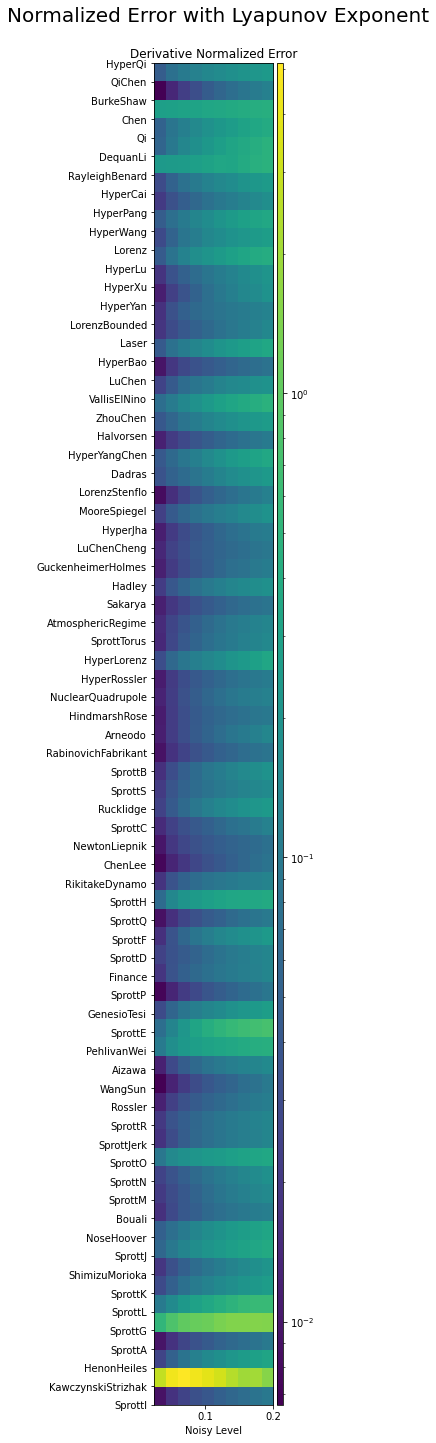

In [11]:
fig, ax2 = plt.subplots(1, 1, figsize=(14, 20))

## derivative trajectory
# form data grid for plotting
chaotic_grid = np.logspace(np.log(np.amin(chaotic_levels)), np.log(np.amax(chaotic_levels)), num_attractors)
# construct y coordinates for contour plot
chaotic_coords = []
for system in systems_list:
    chaotic_coords.append(y_location[re_sys_list.index(system)])
    
chaotic_coords_grid = np.repeat(chaotic_coords, num_error_levels)
error_levels_grid = np.repeat(error_levels, num_attractors)

zz = np.reshape(np.array(dot_perf_list), (num_attractors, num_error_levels))
im2 = ax2.imshow(zz, extent=(np.amin(error_levels), np.amax(error_levels), 
                          np.amin(chaotic_coords_grid), np.amax(chaotic_coords_grid)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Noisy Level', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.suptitle('Normalized Error with Lyapunov Exponent', size=20, y=1)

fig.tight_layout()
fig.show()

# Now repeat for syntactic complexity
First definition we will try is a very simple one... simply count the number of nonzero terms in the governing equations. We will make a histogram of the resulting complexity of each system.

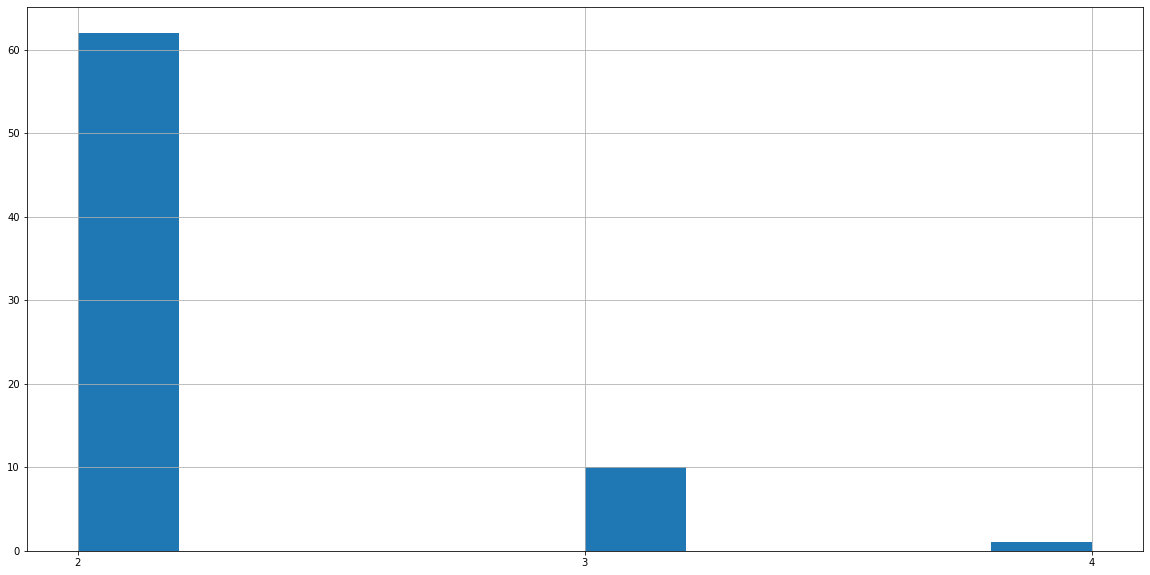

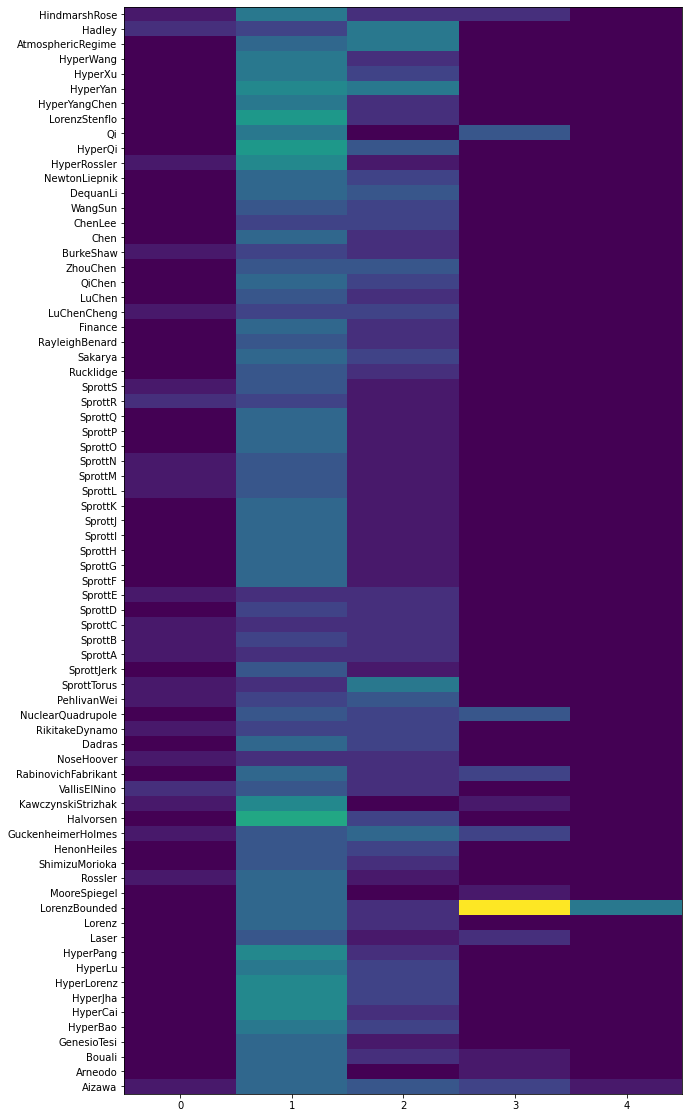

In [12]:
nonlin_list = [4, 3, 3, 
               2, 2, 2, 2, 
               2, 2, 2, 3, 
               2, 2, 3, 2, 2,
               2, 3, 2, 3, 
               2, 3, 2, 2, 2,
               3, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 2, 
               2, 2, 2, 3, 2, 2, 
               2, 2, 2, 2, 2, 3, 
              ]
# number of terms that are constant, linear, quadratic, cubic, and quartic
number_nonlinear_terms = np.zeros((num_attractors, 5)) 
# Aizawa
number_nonlinear_terms[0, 0] = 1
number_nonlinear_terms[0, 1] = 5
number_nonlinear_terms[0, 2] = 4
number_nonlinear_terms[0, 3] = 3
number_nonlinear_terms[0, 4] = 1
# Arneodo
number_nonlinear_terms[1, 1] = 5
number_nonlinear_terms[1, 3] = 1
# Bouali
number_nonlinear_terms[2, 1] = 5
number_nonlinear_terms[2, 2] = 2
number_nonlinear_terms[2, 3] = 1
# GenesioTesi
number_nonlinear_terms[3, 1] = 5
number_nonlinear_terms[3, 2] = 1
# HyperBao
number_nonlinear_terms[4, 1] = 6
number_nonlinear_terms[4, 2] = 3
# HyperCai
number_nonlinear_terms[5, 1] = 7
number_nonlinear_terms[5, 2] = 2
# HyperJha
number_nonlinear_terms[6, 1] = 7
number_nonlinear_terms[6, 2] = 3
# HyperLorenz
number_nonlinear_terms[7, 1] = 7
number_nonlinear_terms[7, 2] = 3
# HyperLu
number_nonlinear_terms[8, 1] = 6
number_nonlinear_terms[8, 2] = 3
# HyperPang
number_nonlinear_terms[9, 1] = 7
number_nonlinear_terms[9, 2] = 2
# Laser
number_nonlinear_terms[10, 1] = 4
number_nonlinear_terms[10, 2] = 1
number_nonlinear_terms[10, 3] = 2
# Lorenz
number_nonlinear_terms[11, 1] = 5
number_nonlinear_terms[11, 2] = 2
# LorenzBounded
number_nonlinear_terms[12, 1] = 5
number_nonlinear_terms[12, 2] = 2
number_nonlinear_terms[12, 3] = 15
number_nonlinear_terms[12, 4] = 6
# MooreSpiegel
number_nonlinear_terms[13, 1] = 5
number_nonlinear_terms[13, 3] = 1
# Rossler
number_nonlinear_terms[14, 0] = 1
number_nonlinear_terms[14, 1] = 5
number_nonlinear_terms[14, 2] = 1
# ShimizuMorioka
number_nonlinear_terms[15, 1] = 4
number_nonlinear_terms[15, 2] = 2
# HenonHeiles
number_nonlinear_terms[16, 1] = 4
number_nonlinear_terms[16, 2] = 3
# GuckenheimerHolmes
number_nonlinear_terms[17, 0] = 1
number_nonlinear_terms[17, 1] = 4
number_nonlinear_terms[17, 2] = 5
number_nonlinear_terms[17, 3] = 3
# Halvorsen
number_nonlinear_terms[18, 1] = 9
number_nonlinear_terms[18, 2] = 3
# KawczynskiStrizhak
number_nonlinear_terms[19, 0] = 1
number_nonlinear_terms[19, 1] = 7
number_nonlinear_terms[19, 3] = 1
# VallisElNino
number_nonlinear_terms[20, 0] = 2
number_nonlinear_terms[20, 1] = 4
number_nonlinear_terms[20, 2] = 2
# RabinovichFabrikant
number_nonlinear_terms[21, 1] = 5
number_nonlinear_terms[21, 2] = 2
number_nonlinear_terms[21, 3] = 3
# NoseHoover
number_nonlinear_terms[22, 0] = 1
number_nonlinear_terms[22, 1] = 2
number_nonlinear_terms[22, 2] = 2
# Dadras
number_nonlinear_terms[23, 1] = 5
number_nonlinear_terms[23, 2] = 3
# RikitakeDynamo
number_nonlinear_terms[24, 0] = 1
number_nonlinear_terms[24, 1] = 3
number_nonlinear_terms[24, 2] = 3
# NuclearQuadrupole
number_nonlinear_terms[25, 1] = 4
number_nonlinear_terms[25, 2] = 3
number_nonlinear_terms[25, 3] = 4
# PehlivanWei
number_nonlinear_terms[26, 0] = 1
number_nonlinear_terms[26, 1] = 3
number_nonlinear_terms[26, 2] = 4
# SprottTorus
number_nonlinear_terms[27, 0] = 1
number_nonlinear_terms[27, 1] = 2
number_nonlinear_terms[27, 2] = 6
# SprottJerk
number_nonlinear_terms[28, 1] = 4
number_nonlinear_terms[28, 2] = 1
# SprottA
number_nonlinear_terms[29, 0] = 1
number_nonlinear_terms[29, 1] = 2
number_nonlinear_terms[29, 2] = 2
# SprottB
number_nonlinear_terms[30, 0] = 1
number_nonlinear_terms[30, 1] = 3
number_nonlinear_terms[30, 2] = 2
# SprottC
number_nonlinear_terms[31, 0] = 1
number_nonlinear_terms[31, 1] = 2
number_nonlinear_terms[31, 2] = 2
# SprottD
number_nonlinear_terms[32, 1] = 3
number_nonlinear_terms[32, 2] = 2
# SprottE
number_nonlinear_terms[33, 0] = 1
number_nonlinear_terms[33, 1] = 2
number_nonlinear_terms[33, 2] = 2
# SprottF
number_nonlinear_terms[34, 1] = 5
number_nonlinear_terms[34, 2] = 1
# SprottG
number_nonlinear_terms[35, 1] = 5
number_nonlinear_terms[35, 2] = 1
# SprottH
number_nonlinear_terms[36, 1] = 5
number_nonlinear_terms[36, 2] = 1
# SprottI
number_nonlinear_terms[37, 1] = 5
number_nonlinear_terms[37, 2] = 1
# SprottJ
number_nonlinear_terms[38, 1] = 5
number_nonlinear_terms[38, 2] = 1
# SprottK
number_nonlinear_terms[39, 1] = 5
number_nonlinear_terms[39, 2] = 1
# SprottL
number_nonlinear_terms[40, 0] = 1
number_nonlinear_terms[40, 1] = 4
number_nonlinear_terms[40, 2] = 1
# SprottM
number_nonlinear_terms[41, 0] = 1
number_nonlinear_terms[41, 1] = 4
number_nonlinear_terms[41, 2] = 1
# SprottN
number_nonlinear_terms[42, 0] = 1
number_nonlinear_terms[42, 1] = 4
number_nonlinear_terms[42, 2] = 1
# SprottO
number_nonlinear_terms[43, 1] = 5
number_nonlinear_terms[43, 2] = 1
# SprottP
number_nonlinear_terms[44, 1] = 5
number_nonlinear_terms[44, 2] = 1
# SprottQ
number_nonlinear_terms[45, 1] = 5
number_nonlinear_terms[45, 2] = 1
# SprottR
number_nonlinear_terms[46, 0] = 2
number_nonlinear_terms[46, 1] = 3
number_nonlinear_terms[46, 2] = 1
# SprottS
number_nonlinear_terms[47, 0] = 1
number_nonlinear_terms[47, 1] = 4
number_nonlinear_terms[47, 2] = 1
# Rucklidge
number_nonlinear_terms[48, 1] = 4
number_nonlinear_terms[48, 2] = 2
# Sakarya
number_nonlinear_terms[49, 1] = 5
number_nonlinear_terms[49, 2] = 3
# RayleighBenard
number_nonlinear_terms[50, 1] = 4
number_nonlinear_terms[50, 2] = 2
# Finance
number_nonlinear_terms[51, 1] = 5
number_nonlinear_terms[51, 2] = 2
# LuChenCheng
number_nonlinear_terms[52, 0] = 1
number_nonlinear_terms[52, 1] = 3
number_nonlinear_terms[52, 2] = 3
# LuChen
number_nonlinear_terms[53, 1] = 4
number_nonlinear_terms[53, 2] = 2
# QiChen
number_nonlinear_terms[54, 1] = 5
number_nonlinear_terms[54, 2] = 3
# ZhouChen
number_nonlinear_terms[55, 1] = 4
number_nonlinear_terms[55, 2] = 4
# BurkeShaw
number_nonlinear_terms[56, 0] = 1
number_nonlinear_terms[56, 1] = 3
number_nonlinear_terms[56, 2] = 2
# Chen
number_nonlinear_terms[57, 1] = 5
number_nonlinear_terms[57, 2] = 2
# ChenLee
number_nonlinear_terms[58, 1] = 3
number_nonlinear_terms[58, 2] = 3
# WangSun
number_nonlinear_terms[59, 1] = 4
number_nonlinear_terms[59, 2] = 3
# DequanLi
number_nonlinear_terms[60, 1] = 5
number_nonlinear_terms[60, 2] = 4
# NewtonLiepnik
number_nonlinear_terms[61, 1] = 5
number_nonlinear_terms[61, 2] = 3
# HyperRossler
number_nonlinear_terms[62, 0] = 1
number_nonlinear_terms[62, 1] = 7
number_nonlinear_terms[62, 2] = 1
# HyperQi
number_nonlinear_terms[63, 1] = 8
number_nonlinear_terms[63, 2] = 4
# Qi
number_nonlinear_terms[64, 1] = 6
number_nonlinear_terms[64, 3] = 4
# LorenzStenflo
number_nonlinear_terms[65, 1] = 8
number_nonlinear_terms[65, 2] = 2
# HyperYangChen
number_nonlinear_terms[66, 1] = 6
number_nonlinear_terms[66, 2] = 2
# HyperYan
number_nonlinear_terms[67, 1] = 7
number_nonlinear_terms[67, 2] = 6
# HyperXu
number_nonlinear_terms[68, 1] = 6
number_nonlinear_terms[68, 2] = 3
# HyperWang
number_nonlinear_terms[69, 1] = 6
number_nonlinear_terms[69, 2] = 2
# AtmosphericRegime
number_nonlinear_terms[70, 1] = 5
number_nonlinear_terms[70, 2] = 6
# Hadley
number_nonlinear_terms[71, 0] = 2
number_nonlinear_terms[71, 1] = 3
number_nonlinear_terms[71, 2] = 6
# Hindmarsh
number_nonlinear_terms[72, 0] = 1
number_nonlinear_terms[72, 1] = 6
number_nonlinear_terms[72, 2] = 2
number_nonlinear_terms[72, 3] = 2

plt.figure()
plt.hist(nonlin_list)
plt.xticks([2, 3, 4])
plt.grid(True)

plt.figure(figsize=(10, 20))
plt.imshow(number_nonlinear_terms, aspect='auto', origin='lower')
plt.yticks(np.arange(num_attractors))
ax = plt.gca()
ax.set_yticklabels(systems_list)
plt.show()

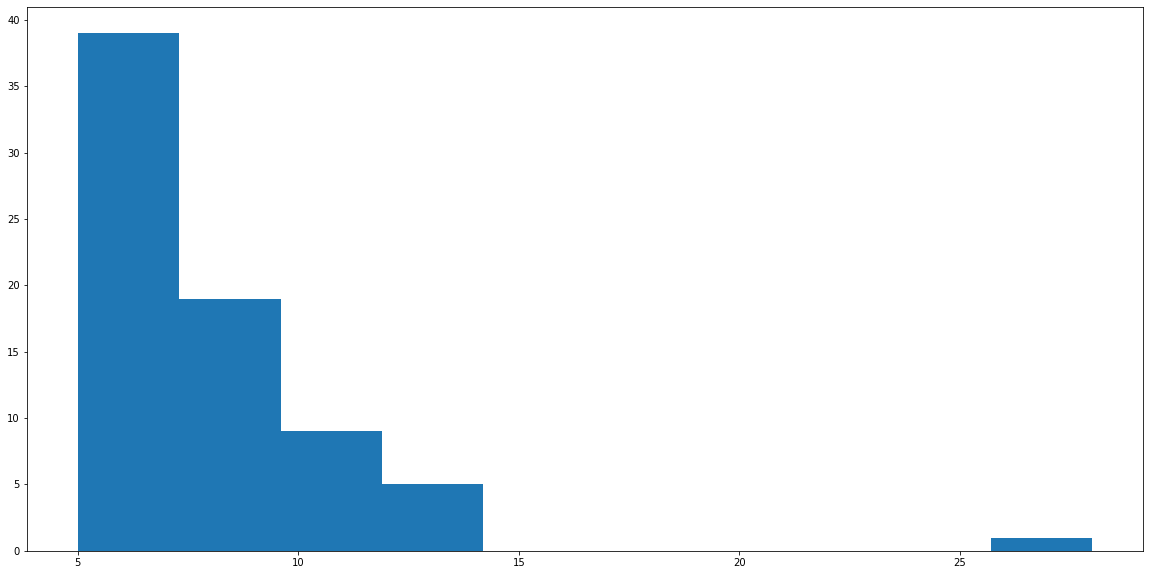

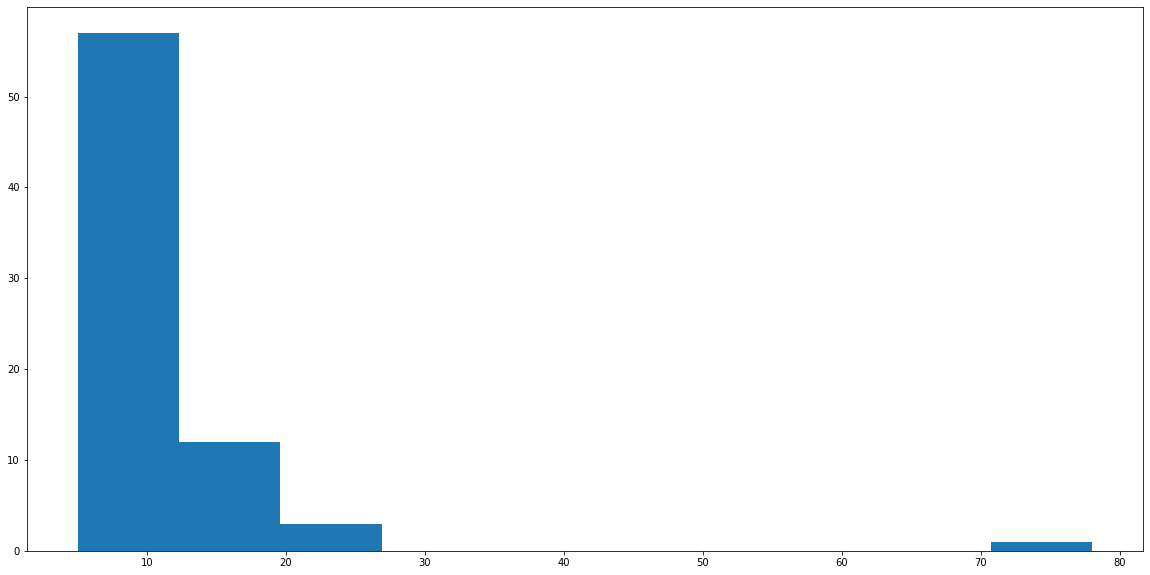

[14.  6.  8.  6.  9.  9. 10. 10.  9.  9.  7.  7. 28.  6.  7.  6.  7. 13.
 12.  9.  8. 10.  5.  8.  7. 11.  8.  9.  5.  5.  6.  5.  5.  5.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  8.  6.  7.  7.  6.
  8.  8.  6.  7.  6.  7.  9.  8.  9. 12. 10. 10.  8. 13.  9.  8. 11. 11.
 11.] [26.  8. 12.  7. 12. 11. 13. 13. 12. 11. 12.  9. 78.  8.  7.  8. 10. 23.
 15. 10.  8. 18.  6. 11.  9. 22. 11. 14.  6.  6.  7.  6.  7.  6.  7.  7.
  7.  7.  7.  7.  6.  6.  6.  7.  7.  7.  5.  6.  8. 11.  8.  9.  9.  8.
 11. 12.  7.  9.  9. 10. 13. 11.  9. 16. 18. 12. 10. 19. 12. 10. 17. 15.
 16.]


In [13]:
# First definition of complexity is just the total number of terms
complexity1 = np.sum(number_nonlinear_terms, axis=-1)
plt.figure()
plt.hist(complexity1)
plt.show()

# Second definition of complexity is the terms weighted by the polynomial order
weights = np.ones((num_attractors, 5)) 
for i in range(num_attractors):
    weights[i, :] = weights[i, :] * np.array([0, 1, 2, 3, 4])
complexity2 = np.sum(number_nonlinear_terms * weights, axis=-1)
plt.figure()
plt.hist(complexity2)
plt.show()
print(complexity1, complexity2)

[ 5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.
  9.  9.  9.  9. 10. 10. 10. 10. 10. 11. 11. 11. 11. 12. 12. 13. 13. 14.
 28.] ['SprottC' 'NoseHoover' 'SprottD' 'SprottE' 'SprottA' 'SprottJerk'
 'SprottS' 'ChenLee' 'SprottB' 'BurkeShaw' 'LuChen' 'SprottF' 'SprottG'
 'SprottI' 'Rucklidge' 'SprottJ' 'SprottL' 'RayleighBenard' 'SprottN'
 'SprottO' 'SprottP' 'SprottQ' 'SprottR' 'SprottK' 'SprottM' 'SprottH'
 'GenesioTesi' 'Arneodo' 'ShimizuMorioka' 'MooreSpiegel' 'HenonHeiles'
 'LuChenCheng' 'RikitakeDynamo' 'WangSun' 'Chen' 'Laser' 'Lorenz'
 'Finance' 'Rossler' 'QiChen' 'HyperYangChen' 'PehlivanWei' 'Bouali'
 'HyperWang' 'VallisElNino' 'Dadras' 'NewtonLiepnik' 'ZhouChen' 'Sakarya'
 'DequanLi' 'HyperPang' 'HyperCai' 'HyperLu' 'HyperXu'
 'KawczynskiStrizhak' 'HyperRossler' 'SprottTorus' 'HyperBao' 'HyperJha'
 'HyperLorenz'

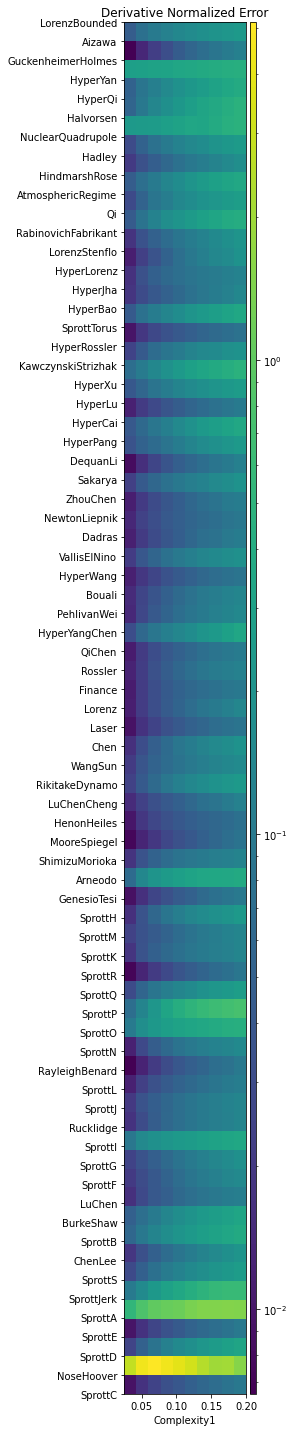

In [14]:
fig, ax2 = plt.subplots(1, 1, figsize=(14, 20))
    
re_idx = np.argsort(complexity1)
print(complexity1[re_idx], np.array(systems_list)[re_idx])
re_sys_list = [systems_list[i] for i in re_idx]

complexity_grid = np.linspace(np.amin(complexity1), np.amax(complexity1), num_attractors)
# construct y coordinates for contour plot
complexity_coords = []
for system in systems_list:
    complexity_coords.append(y_location[re_sys_list.index(system)])
    
complexity_coords_grid = np.repeat(complexity_coords, num_error_levels)
error_levels_grid = np.repeat(error_levels, num_attractors)

zz = np.reshape(np.array(dot_perf_list), (num_attractors, num_error_levels))
im2 = ax2.imshow(zz, extent=(np.amin(error_levels), np.amax(error_levels), 
                          np.amin(complexity_coords_grid), np.amax(complexity_coords_grid)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Complexity1', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.tight_layout()
fig.show()

[ 5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12.
 12. 12. 12. 13. 13. 13. 14. 15. 15. 16. 16. 17. 18. 18. 19. 22. 23. 26.
 78.] ['SprottR' 'SprottC' 'SprottA' 'SprottE' 'SprottJerk' 'SprottL' 'SprottM'
 'NoseHoover' 'SprottS' 'SprottN' 'SprottO' 'SprottP' 'SprottQ' 'SprottJ'
 'SprottI' 'SprottG' 'SprottF' 'SprottD' 'SprottB' 'BurkeShaw' 'SprottK'
 'SprottH' 'GenesioTesi' 'Rossler' 'VallisElNino' 'Arneodo' 'LuChen'
 'RayleighBenard' 'Rucklidge' 'ShimizuMorioka' 'MooreSpiegel' 'ChenLee'
 'Chen' 'LuChenCheng' 'Finance' 'Lorenz' 'HyperRossler' 'RikitakeDynamo'
 'HyperWang' 'HenonHeiles' 'WangSun' 'HyperYangChen' 'KawczynskiStrizhak'
 'Dadras' 'QiChen' 'PehlivanWei' 'Sakarya' 'HyperCai' 'HyperPang'
 'NewtonLiepnik' 'Bouali' 'HyperXu' 'HyperBao' 'ZhouChen' 'LorenzStenflo'
 'HyperLu' 'Laser' 'HyperJha' 'DequanLi' 'HyperLorenz

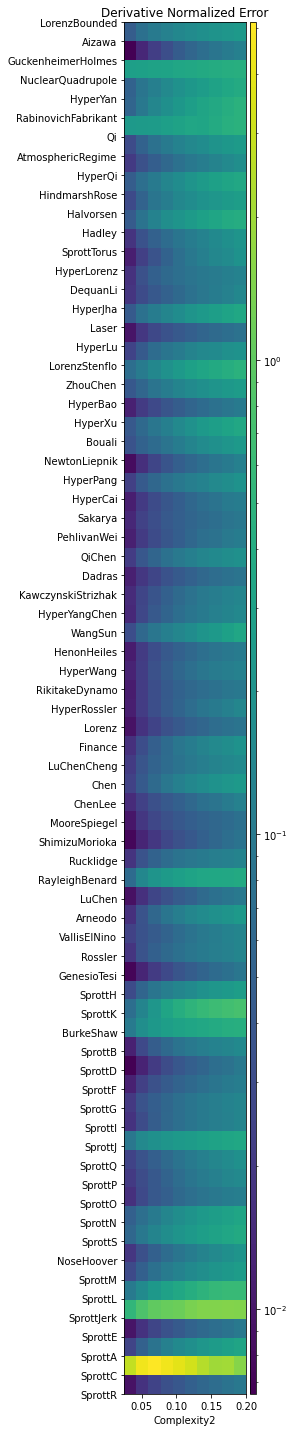

In [15]:
fig, ax2 = plt.subplots(1, 1, figsize=(14, 20))
    
re_idx = np.argsort(complexity2)
print(complexity2[re_idx], np.array(systems_list)[re_idx])
re_sys_list = [systems_list[i] for i in re_idx]

complexity_grid = np.linspace(np.amin(complexity2), np.amax(complexity2), num_attractors)
# construct y coordinates for contour plot
complexity_coords = []
for system in systems_list:
    complexity_coords.append(y_location[re_sys_list.index(system)])
    
complexity_coords_grid = np.repeat(complexity_coords, num_error_levels)
error_levels_grid = np.repeat(error_levels, num_attractors)

zz = np.reshape(np.array(dot_perf_list), (num_attractors, num_error_levels))
im2 = ax2.imshow(zz, extent=(np.amin(error_levels), np.amax(error_levels), 
                          np.amin(complexity_coords_grid), np.amax(complexity_coords_grid)),
                 norm=LogNorm(vmin=zz.min(), vmax=zz.max()), origin="lower")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# add text descriptions
ax2.title.set_text("Derivative Normalized Error")
ax2.set(xlabel='Complexity2', ylabel='')

# replace y tick
ax2.set_yticks(y_location)
ax2.set_yticklabels(re_sys_list)

fig.tight_layout()
fig.show()